In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import lsst.sims.maf.plots as plots
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db

In [11]:
# hack to get the path right
import sys
sys.path.append('..')
sys.path.append('~/Eric/LSST/sims_maf_contrib/mafContrib')

from ztf_maf.slicers import HealpixZTFSlicer
from ztf_maf.plots import ZTFBaseSkyMap

from mafContrib import GRBTransientMetric

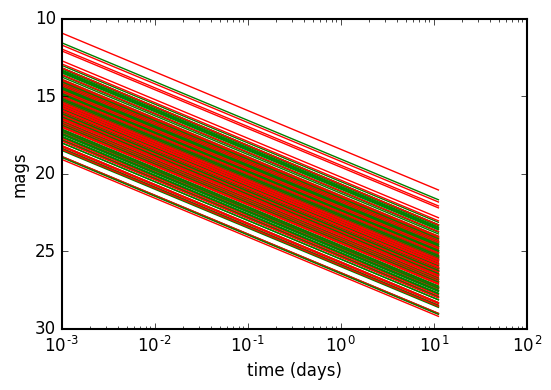

In [28]:
transDuration = 30
transMetric = GRBTransientMetric(alpha= 1., surveyDuration=0.5, nPerLC=3, transDuration=trandDuration)
colors = ['g','r']
filterNames = ['g','r']

times = np.logspace(-3,1.05,500)
for i in range(100):
    for filterName, color in zip(filterNames,colors):
        filters = np.array([filterName]*times.size)
        lc = transMetric.lightCurve(times % transDuration,filters)
        plt.plot(times,lc, color, label=filterName)
plt.xlabel('time (days)')
plt.ylabel('mags')
plt.gca().invert_yaxis()
plt.xscale('log')
#plt.legend()

In [19]:
slicer = HealpixZTFSlicer(nside=64, lonCol='fieldRA', latCol='fieldDec')
#slicer = slicers.OpsimFieldSlicer()
#slicer.plotFuncs = [ZTFBaseSkyMap, plots.OpsimHistogram]

# see https://github.com/LSST-nonproject/sims_maf_contrib/blob/master/workshops/UK_2015/Cambridge_MAFIntro.pdf for more

metricList = []


metricList.append(transMetric)



filters = ['r','g']
programs = [1,2,3]

summaryMetrics = [metrics.MinMetric(), metrics.MeanMetric(), metrics.MaxMetric(), 
                  metrics.MedianMetric(), metrics.RmsMetric(), 
                 metrics.PercentileMetric(percentile=25), metrics.PercentileMetric(percentile=75)]

   
bDict={}
for i,metric in enumerate(metricList):
    
    # exclude Caltech time
    sqlconstraint = "propID != '3'"

    bDict[sqlconstraint] = metricBundles.MetricBundle(metric, slicer, sqlconstraint, 
                                              summaryMetrics=summaryMetrics)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


Querying database with constraint propID != '3'
Found 60528 visits
Running:  ["propID != '3'"]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with propID != '3' constraint now.
Plotting complete.


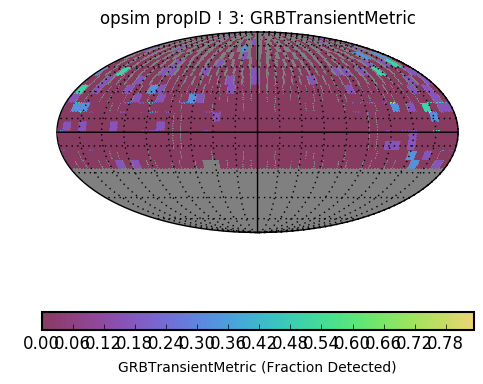

In [20]:
outDir = 'ZTF_test'
ztfDB = db.OpsimDatabase('../sims/one_year_sim_incomplete.db',
                        defaultdbTables={'Summary':['Summary','obsHistID']})
ztfDB.raColName = 'fieldRA'
ztfDB.decColName = 'fieldDec'

resultsDb = db.ResultsDb(outDir=outDir)

bgroup = metricBundles.MetricBundleGroup(bDict, ztfDB, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)

In [21]:
for key in sorted(bDict):
    bDict[key].computeSummaryStats(resultsDb=resultsDb)
    print key, bDict[key].metric.name, bDict[key].summaryValues

propID != '3' GRBTransientMetric {'25th%ile': 0.0, 'Rms': 0.075637011572514054, '75th%ile': 0.0, 'Min': 0.0, 'Max': 0.83333333333333337, 'Median': 0.0, 'Mean': 0.023511798981119474}
